# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [1]:
import os

os.makedirs("module", exist_ok=True)

In [ ]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ############ 1 epoch 학습 종료 -> LR 를 변경 ###########
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Writing module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [3]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Writing module/data.py


## utils.py


In [4]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Writing module/utils.py


## Import

In [3]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [7]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

100.0%
100.0%
100.0%
100.0%


In [12]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

In [13]:
classes, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [6]:
class SmallModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.lr = nn.Linear(28*28, 10) # input -> output

	def forward(self, X):
		X = nn.Flatten()(X)
		out = self.lr(X)
		return out

In [7]:
small_model = SmallModel().to(device)
summary(small_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr = lr)

In [28]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
	train_loader,
	test_loader,
	small_model,
	loss_fn,
	optimizer,
	epochs,
	save_best_model=False,
	device=device,
	mode="multi"
)

Epoch[1/100] - Train loss: 0.48626 Train Accucracy: 0.88273 || Validation Loss: 0.46247 Validation Accuracy: 0.89130
Epoch[2/100] - Train loss: 0.38075 Train Accucracy: 0.89945 || Validation Loss: 0.36175 Validation Accuracy: 0.90590
Epoch[3/100] - Train loss: 0.33952 Train Accucracy: 0.90798 || Validation Loss: 0.32299 Validation Accuracy: 0.91230
Epoch[4/100] - Train loss: 0.31663 Train Accucracy: 0.91425 || Validation Loss: 0.30316 Validation Accuracy: 0.91620
Epoch[5/100] - Train loss: 0.30317 Train Accucracy: 0.91752 || Validation Loss: 0.29336 Validation Accuracy: 0.91790
Epoch[6/100] - Train loss: 0.29353 Train Accucracy: 0.91882 || Validation Loss: 0.28554 Validation Accuracy: 0.91960
Epoch[7/100] - Train loss: 0.28551 Train Accucracy: 0.92143 || Validation Loss: 0.27908 Validation Accuracy: 0.92090
Epoch[8/100] - Train loss: 0.27946 Train Accucracy: 0.92297 || Validation Loss: 0.27481 Validation Accuracy: 0.92300
Epoch[9/100] - Train loss: 0.27377 Train Accucracy: 0.92337 || V

KeyboardInterrupt: 

## 큰모델

In [32]:
# nn.Sequential() -> layer block : layer 함수들을 묶어 놓은 블락!
s = nn.Sequential(
	nn.Linear(10,20),
	nn.ReLU(),
	nn.Linear(20,30),
	nn.ReLU()
)

i = torch.randn(5, 10, dtype=torch.float32)
o = s(i)
o.shape,\
o

(torch.Size([5, 30]),
 tensor([[0.0000e+00, 3.5638e-02, 6.3693e-01, 1.2873e-01, 3.9534e-01, 0.0000e+00,
          0.0000e+00, 1.8939e-01, 6.7658e-03, 1.4226e-01, 0.0000e+00, 5.3165e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3889e-01, 3.1409e-01, 1.3951e-01,
          2.4961e-01, 1.0150e-01, 2.8279e-02, 0.0000e+00, 0.0000e+00, 2.6725e-01,
          6.6737e-02, 0.0000e+00, 3.0599e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.5706e-02, 4.3953e-01, 3.5045e-01, 2.7992e-01, 7.5637e-02,
          7.1252e-02, 0.0000e+00, 0.0000e+00, 1.2387e-01, 0.0000e+00, 5.0656e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5463e-01, 3.6711e-01, 1.3260e-01,
          8.0387e-02, 2.4028e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7722e-01,
          2.4149e-01, 6.8595e-02, 1.4172e-01, 2.6444e-01, 0.0000e+00, 0.0000e+00],
         [2.0914e-01, 2.2574e-01, 3.7691e-01, 7.3448e-02, 2.4539e-01, 2.4024e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8706e-01, 1.8784e-02, 2.42

In [46]:
class BigModel(nn.Module):

	def __init__(self):
		super().__init__()
		self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
		self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
		self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
		self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
		self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
		self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
		self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
		self.out_block = nn.Linear(32, 10)

	def forward(self, X):
		X = self.b1(X)
		X = self.b2(X)
		X = self.b3(X)
		X = self.b4(X)
		X = self.b5(X)
		X = self.b6(X)
		X = self.b7(X)
		return self.out_block(X)

In [47]:
big_model = BigModel().to(device)
summary(big_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-4                       [100, 1024]               2,098,176
│    └─ReLU: 2-5                         [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-6                       [100, 512]                524,800
│    └─ReLU: 2-7                         [100, 512]                --
├─Sequential: 1-4                        [100, 256]                --
│    └─Linear: 2-8                       [100, 256]               

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr = lr)

In [49]:
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = fit(
	train_loader,test_loader,
	big_model,
	loss_fn,
	optimizer,
	epochs,
	save_best_model=False,
	patience=5,
	device=device,
	mode="multi"
)

Epoch[1/100] - Train loss: 0.16665 Train Accucracy: 0.95185 || Validation Loss: 0.17319 Validation Accuracy: 0.94790
Epoch[2/100] - Train loss: 0.10251 Train Accucracy: 0.97013 || Validation Loss: 0.12618 Validation Accuracy: 0.96320
Epoch[3/100] - Train loss: 0.06004 Train Accucracy: 0.98257 || Validation Loss: 0.09391 Validation Accuracy: 0.97290
Epoch[4/100] - Train loss: 0.04243 Train Accucracy: 0.98795 || Validation Loss: 0.08400 Validation Accuracy: 0.97470
Epoch[5/100] - Train loss: 0.04104 Train Accucracy: 0.98735 || Validation Loss: 0.08596 Validation Accuracy: 0.97550
Epoch[6/100] - Train loss: 0.02251 Train Accucracy: 0.99337 || Validation Loss: 0.07950 Validation Accuracy: 0.97900
Epoch[7/100] - Train loss: 0.02202 Train Accucracy: 0.99340 || Validation Loss: 0.08063 Validation Accuracy: 0.97870
Epoch[8/100] - Train loss: 0.03065 Train Accucracy: 0.99105 || Validation Loss: 0.08979 Validation Accuracy: 0.97660
Epoch[9/100] - Train loss: 0.01879 Train Accucracy: 0.99438 || V

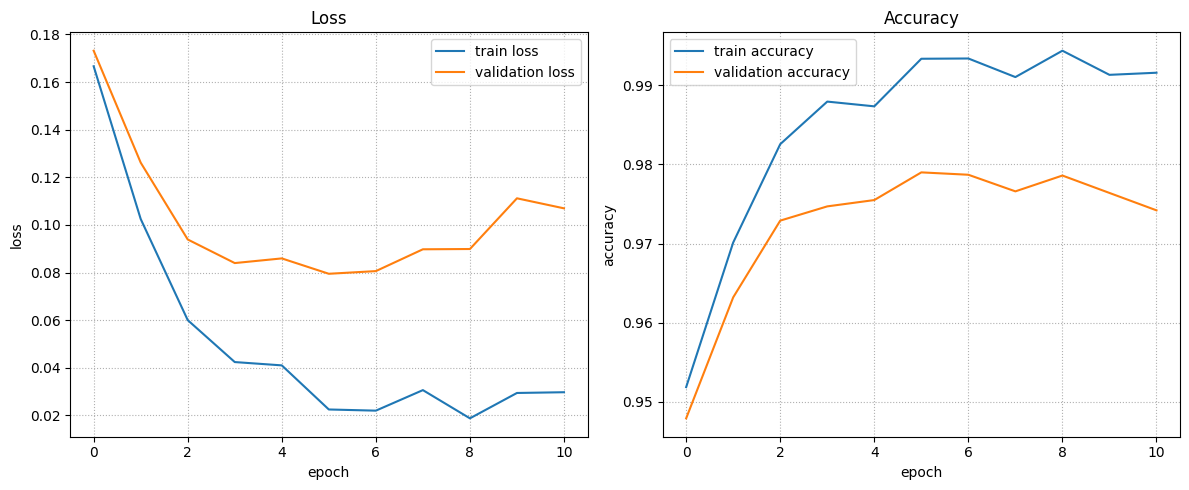

In [50]:
plot_fit_result(
	train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2
)

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [58]:
class DropoutModel(nn.Module):

	def __init__(self, drop_rate=0.2):
		super().__init__()
		self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.out_block = nn.Linear(32, 10)

	def forward(self, X):
		X = self.b1(X)
		X = self.b2(X)
		X = self.b3(X)
		X = self.b4(X)
		X = self.b5(X)
		X = self.b6(X)
		X = self.b7(X)
		return self.out_block(X)

In [59]:
dout_model = DropoutModel(drop_rate=0.5).to(device)
summary(dout_model, (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─ReLU: 2-6                         [100, 1024]               --
│    └─Dropout: 2-7                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-8                       [100, 512]                524,800
│    └─ReLU: 2-9                         [100, 512]               

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr = lr)

In [61]:
train_loss_list3, train_acc_list3, valid_loss_list3, valid_acc_list3 = fit(
	train_loader, test_loader,
	dout_model,
	loss_fn,
	optimizer,
	epochs,
	save_best_model=False,
	patience=5,
	device=device,
	mode = "multi"
)

Epoch[1/100] - Train loss: 1.04149 Train Accucracy: 0.49033 || Validation Loss: 1.04356 Validation Accuracy: 0.49370
Epoch[2/100] - Train loss: 0.77618 Train Accucracy: 0.67332 || Validation Loss: 0.78724 Validation Accuracy: 0.66880
Epoch[3/100] - Train loss: 0.66121 Train Accucracy: 0.76955 || Validation Loss: 0.70648 Validation Accuracy: 0.76900
Epoch[4/100] - Train loss: 0.45047 Train Accucracy: 0.84953 || Validation Loss: 0.49261 Validation Accuracy: 0.85330
Epoch[5/100] - Train loss: 0.32703 Train Accucracy: 0.93037 || Validation Loss: 0.35800 Validation Accuracy: 0.92710
Epoch[6/100] - Train loss: 0.28816 Train Accucracy: 0.92857 || Validation Loss: 0.34054 Validation Accuracy: 0.92590
Epoch[7/100] - Train loss: 0.22183 Train Accucracy: 0.95165 || Validation Loss: 0.29576 Validation Accuracy: 0.94570
Epoch[8/100] - Train loss: 0.16932 Train Accucracy: 0.96407 || Validation Loss: 0.25916 Validation Accuracy: 0.95620
Epoch[9/100] - Train loss: 0.14971 Train Accucracy: 0.96695 || V

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [5]:
# nn.BatchNorm1d(input feature 개수)
# Linear -> BatchNorm -> Activation func(ReLU) -> Dropout

class BatchNormModel(nn.Module):

	def __init__(self, drop_rate=0.2):
		super().__init__()
		self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(),nn.BatchNorm1d(1024), nn.Dropout(p=drop_rate))
		self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(),nn.BatchNorm1d(512), nn.Dropout(p=drop_rate))
		self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=drop_rate))
		self.out_block = nn.Linear(32, 10)

	def forward(self, X):
		X = self.b1(X)
		X = self.b2(X)
		X = self.b3(X)
		X = self.b4(X)
		X = self.b5(X)
		X = self.b6(X)
		X = self.b7(X)
		return self.out_block(X)

In [63]:
bn_model = BatchNormModel(drop_rate=0.5).to(device)
summary(bn_model, (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormModel                           [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─BatchNorm1d: 2-3                  [100, 2048]               4,096
│    └─ReLU: 2-4                         [100, 2048]               --
│    └─Dropout: 2-5                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-6                       [100, 1024]               2,098,176
│    └─ReLU: 2-7                         [100, 1024]               --
│    └─BatchNorm1d: 2-8                  [100, 1024]               2,048
│    └─Dropout: 2-9                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]              

In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr = lr)

In [65]:
train_loss_list4, train_acc_list4, valid_loss_list4, valid_acc_list4 = fit(
	train_loader,test_loader,
	bn_model,
	loss_fn,
	optimizer,
	epochs,
	save_best_model=False,
	patience=5,
	device=device,
	mode="multi"
)

Epoch[1/100] - Train loss: 0.45586 Train Accucracy: 0.92857 || Validation Loss: 0.45529 Validation Accuracy: 0.93020
Epoch[2/100] - Train loss: 0.18773 Train Accucracy: 0.95488 || Validation Loss: 0.19764 Validation Accuracy: 0.95110
Epoch[3/100] - Train loss: 0.12286 Train Accucracy: 0.97082 || Validation Loss: 0.14133 Validation Accuracy: 0.96540
Epoch[4/100] - Train loss: 0.10034 Train Accucracy: 0.97497 || Validation Loss: 0.12027 Validation Accuracy: 0.96980
Epoch[5/100] - Train loss: 0.09188 Train Accucracy: 0.97827 || Validation Loss: 0.11905 Validation Accuracy: 0.97250
Epoch[6/100] - Train loss: 0.08082 Train Accucracy: 0.98117 || Validation Loss: 0.10875 Validation Accuracy: 0.97450
Epoch[7/100] - Train loss: 0.07452 Train Accucracy: 0.98243 || Validation Loss: 0.11195 Validation Accuracy: 0.97370
Epoch[8/100] - Train loss: 0.06119 Train Accucracy: 0.98537 || Validation Loss: 0.09767 Validation Accuracy: 0.97780
Epoch[9/100] - Train loss: 0.05759 Train Accucracy: 0.98608 || V

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [1]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

#### StepLR


In [9]:
small_model = SmallModel()
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)

# optimizer에서 현재 LR을 조회
optim.param_groups

[{'params': [Parameter containing:
   tensor([[-0.0002,  0.0085,  0.0271,  ...,  0.0073, -0.0093,  0.0256],
           [-0.0106, -0.0337, -0.0349,  ...,  0.0248, -0.0291, -0.0243],
           [-0.0017,  0.0040, -0.0347,  ...,  0.0088, -0.0308,  0.0242],
           ...,
           [-0.0226, -0.0303,  0.0011,  ..., -0.0203,  0.0289, -0.0344],
           [ 0.0095,  0.0150,  0.0063,  ...,  0.0278,  0.0248,  0.0074],
           [-0.0252,  0.0020,  0.0164,  ..., -0.0290,  0.0134,  0.0017]],
          requires_grad=True),
   Parameter containing:
   tensor([-3.0127e-02,  1.3994e-02, -5.9691e-03, -1.6394e-02,  3.5621e-05,
            3.5201e-03, -1.4999e-03, -2.8241e-02,  2.7072e-02,  4.6563e-03],
          requires_grad=True)],
  'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'decoupled_weight_decay': False}]

In [ ]:
# LearningRate Scheduler - StepLR : 계단 형태로 LR를 특정 step마다 특정 비율로 줄여나감.
steplr_scheduler = torch.optim.lr_scheduler.StepLR(
	optim,			# 학습률을 변경할 optimizer
	step_size=30,	# 몇 step or epoch(모델 생성해주기에 따라)마다 LR을 변경할지 -> lr_schedular.step() : 30번 실행되면 변경
	gamma=0.5		# 변경할 비율
)

# --> 30step or epoch마다 LR을 "현재학습률 * gamma"로 변경

# 현재 LR을 scheduler로 부터 조회
steplr_scheduler.get_last_lr()

[0.001]

In [29]:
# model 생성
# loss func 생성
# optimizer 생성
# LR scheduler 생성

# 학습
epochs = 300
step_size = 10	# len(dataloader)
lr_list = []

for epoch in range(epochs):

	for step in range(step_size):	# for x, y in dataloader
		# 1 step 학습
		# x, y device로 ㄹ이동
		# 추론 : p = model(x)
		# loss : loss = loss_fn(p, y)
		# grad : loss.backward()
		optim.step()		# update
		optim.zero_grad()	# grad 초기화

		# steplr_scheduler.step()	# 1 step 당 LR 변경 요청
		# lr_list.append(steplr_scheduler.get_last_lr())	# step() 후 lr을 list에 저장.

	steplr_scheduler.step()	# 1 epoch 당 LR 변경 요청
	lr_list.append(steplr_scheduler.get_last_lr())	# step() 후 lr을 list에 저장.

In [17]:
lr_list

[[7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [7.888609052210118e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.944304526105059e-34],
 [3.94430452

c:\Users\Playdata\miniconda3\envs\dl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


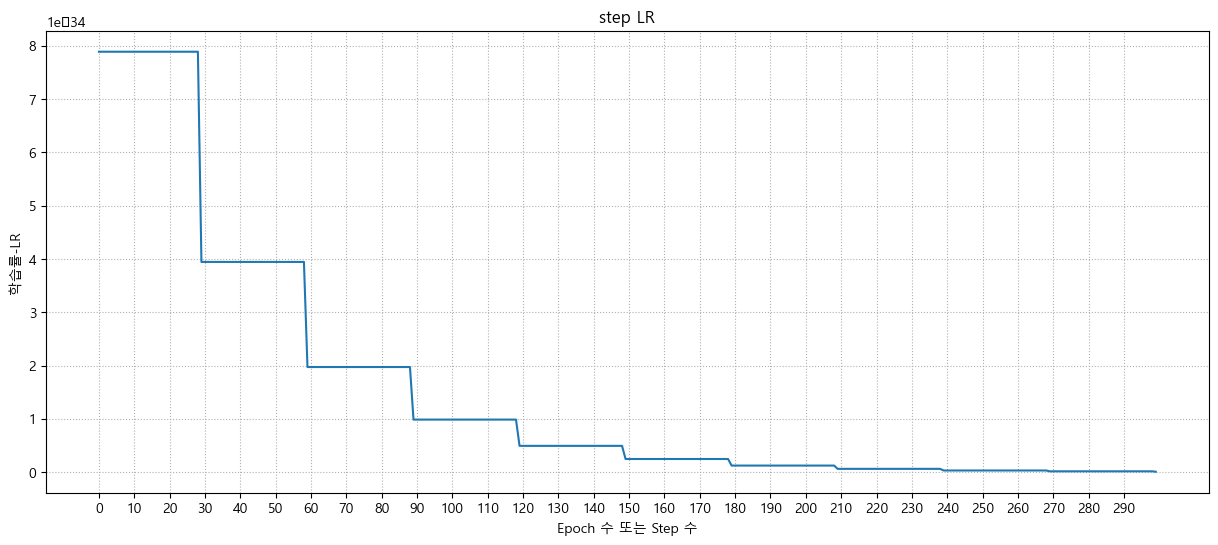

In [18]:
plt.rcParams["font.family"] = "malgun gothic"
plot_lr("step LR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [30]:
optim = torch.optim.Adam(small_model.parameters(), lr = 0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
	optim,
	T_max = 10,		# 변화주기 step/epoch - 최대(초기LR) ~ 최소(eta_min), 최소 ~ 최대
	eta_min=1e-6	# lr 최소값 지정
)

In [31]:
for epoch in range(epochs):
	for step in range(step_size):
		# ... 학습
		optim.step()
		optim.zero_grad()

	ca_lr_scheduler.step()	# epoch 단위로 lr 변경
	lr_list.append(ca_lr_scheduler.get_last_lr())

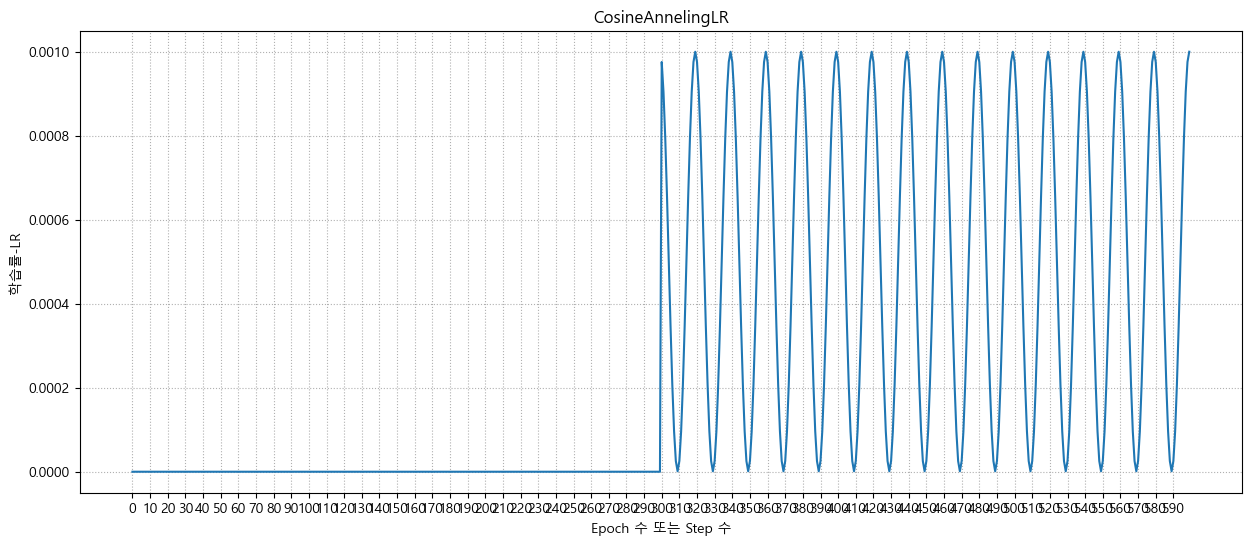

In [32]:
plot_lr("CosineAnnelingLR", lr_list)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [34]:
optim = torch.optim.Adam(small_model.parameters(), lr = 0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
	optim,
	T_0=10,		# 변화주기 (step or epoch)
	T_mult=2,	# 새로운 변화주기(T_0) = 현재 T_0 * T_mult (한 주기가 끝날 때 마다 T_0 다시 계산)
	eta_min=1e-6
)

In [35]:
lr_list = []
for epoch in range(epochs):

	for step in range(step_size):
		# 학습
		optim.step()
		optim.zero_grad()

	cawr_lr_scheduler.step()
	lr_list.append(cawr_lr_scheduler.get_last_lr())

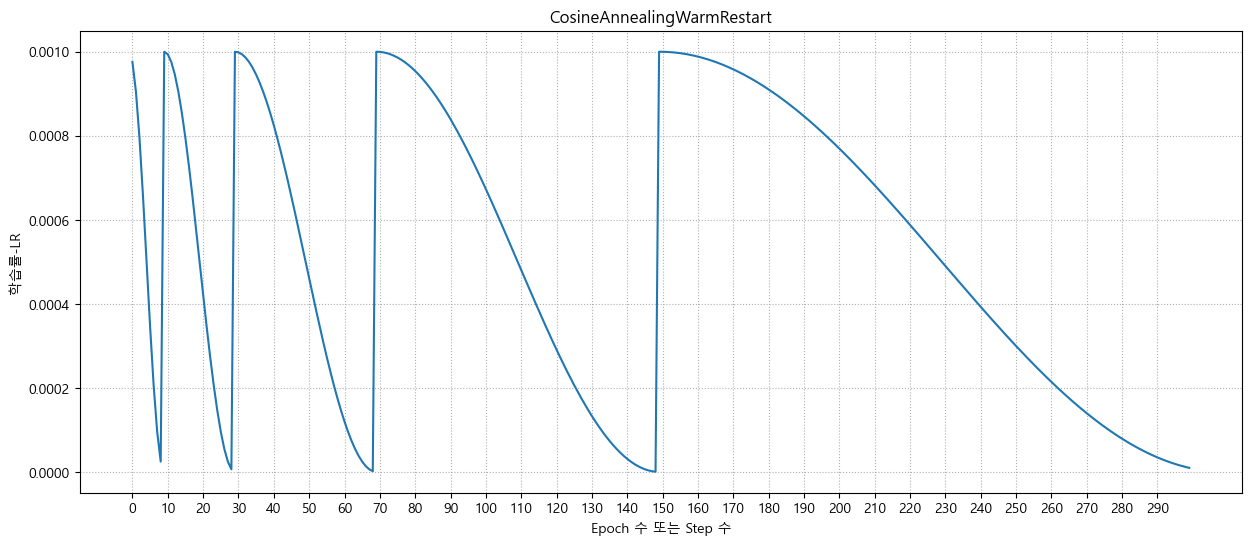

In [36]:
plot_lr("CosineAnnealingWarmRestart", lr_list)